In [1]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
## Creates the sqlalchemy engine and uses a SQL query to store the data in a dataframe
engine = create_engine('sqlite:///mta.db')
turnstiles_df = pd.read_sql('SELECT * FROM mta_data;', engine)
turnstiles_df

,CA,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/30/2021,03:00:00,REGULAR,7524539,2564693
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/30/2021,07:00:00,REGULAR,7524543,2564703
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/30/2021,11:00:00,REGULAR,7524566,2564755
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/30/2021,15:00:00,RECOVR AUD,7524643,2564793
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/30/2021,19:00:00,REGULAR,7524739,2564811
...,...,...,...,...,...,...,...,...,...,...,...
3554423,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,05/28/2021,08:20:35,REGULAR,5554,577
3554424,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,05/28/2021,09:00:00,REGULAR,5554,577
3554425,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,05/28/2021,13:00:00,REGULAR,5554,577
3554426,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,05/28/2021,17:00:00,REGULAR,5554,577


In [3]:
turnstiles_daily = (turnstiles_df
                        .groupby(["CA", "UNIT", "SCP", "STATION", "DATE"],as_index=False)
                        .ENTRIES.first())
turnstiles_daily

,CA,UNIT,SCP,STATION,DATE,ENTRIES
0,A002,R051,02-00-00,59 ST,01/30/2021,7524539
1,A002,R051,02-00-00,59 ST,01/31/2021,7524826
2,A002,R051,02-00-00,59 ST,02/01/2021,7525092
3,A002,R051,02-00-00,59 ST,02/02/2021,7525267
4,A002,R051,02-00-00,59 ST,02/03/2021,7525606
...,...,...,...,...,...,...
594092,TRAM2,R469,00-05-01,RIT-ROOSEVELT,05/24/2021,5554
594093,TRAM2,R469,00-05-01,RIT-ROOSEVELT,05/25/2021,5554
594094,TRAM2,R469,00-05-01,RIT-ROOSEVELT,05/26/2021,5554
594095,TRAM2,R469,00-05-01,RIT-ROOSEVELT,05/27/2021,5554


In [4]:
turnstiles_daily['DAILY_TOT'] = turnstiles_daily.groupby(["CA", "UNIT", "SCP", "STATION"]).ENTRIES.diff()
turnstiles_daily['DAILY_TOT_ABS'] = np.absolute(turnstiles_daily.DAILY_TOT)

In [5]:
turnstiles_daily.to_csv('temp.csv')

In [6]:
mask = (turnstiles_daily.DAILY_TOT_ABS < 10000)
turnstiles_daily_cleaned = turnstiles_daily[mask]
turnstiles_daily_cleaned

,CA,UNIT,SCP,STATION,DATE,ENTRIES,DAILY_TOT,DAILY_TOT_ABS
1,A002,R051,02-00-00,59 ST,01/31/2021,7524826,287.0,287.0
2,A002,R051,02-00-00,59 ST,02/01/2021,7525092,266.0,266.0
3,A002,R051,02-00-00,59 ST,02/02/2021,7525267,175.0,175.0
4,A002,R051,02-00-00,59 ST,02/03/2021,7525606,339.0,339.0
5,A002,R051,02-00-00,59 ST,02/04/2021,7526176,570.0,570.0
...,...,...,...,...,...,...,...,...
594092,TRAM2,R469,00-05-01,RIT-ROOSEVELT,05/24/2021,5554,0.0,0.0
594093,TRAM2,R469,00-05-01,RIT-ROOSEVELT,05/25/2021,5554,0.0,0.0
594094,TRAM2,R469,00-05-01,RIT-ROOSEVELT,05/26/2021,5554,0.0,0.0
594095,TRAM2,R469,00-05-01,RIT-ROOSEVELT,05/27/2021,5554,0.0,0.0


In [7]:
station_daily = turnstiles_daily_cleaned.groupby(['STATION','DATE'])[['DAILY_TOT_ABS']].sum().reset_index()
station_daily_sum = station_daily.groupby('STATION').DAILY_TOT_ABS.sum().reset_index().sort_values('DAILY_TOT_ABS',ascending = False).head(15)

station_daily_sum.head(5)

,STATION,DAILY_TOT_ABS
61,34 ST-PENN STA,3636771.0
59,34 ST-HERALD SQ,3017677.0
110,86 ST,2940086.0
9,125 ST,2783455.0
233,GRD CNTRL-42 ST,2609949.0


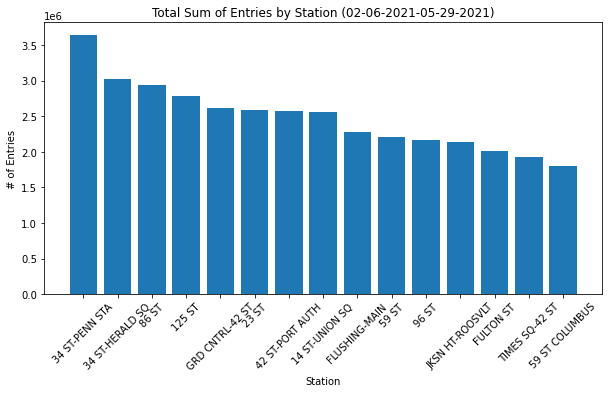

In [8]:
plt.figure(figsize=(10,5)) 
plt.bar(station_daily_sum.STATION, station_daily_sum.DAILY_TOT_ABS)
plt.ylabel('# of Entries')
plt.xlabel('Station')
plt.xticks(rotation=45)
plt.title('Total Sum of Entries by Station (02-06-2021-05-29-2021)')

plt.savefig('tot_sum_by_stat.png', bbox_inches = 'tight')

In [9]:
single_station_penn = turnstiles_daily_cleaned[turnstiles_daily_cleaned['STATION'] == '34 ST-PENN STA'].groupby('DATE').DAILY_TOT_ABS.sum().reset_index()
single_station_herald = turnstiles_daily_cleaned[turnstiles_daily_cleaned['STATION'] == '34 ST-HERALD SQ'].groupby('DATE').DAILY_TOT_ABS.sum().reset_index()
single_station_86 = turnstiles_daily_cleaned[turnstiles_daily_cleaned['STATION'] == '86 ST'].groupby('DATE').DAILY_TOT_ABS.sum().reset_index()
single_station_125 = turnstiles_daily_cleaned[turnstiles_daily_cleaned['STATION'] == '125 ST'].groupby('DATE').DAILY_TOT_ABS.sum().reset_index()
single_station_grd_central = turnstiles_daily_cleaned[turnstiles_daily_cleaned['STATION'] == 'GRD CNTRL-42 ST'].groupby('DATE').DAILY_TOT_ABS.sum().reset_index()

single_station_penn.head()

,DATE,DAILY_TOT_ABS
0,01/31/2021,16353.0
1,02/01/2021,14159.0
2,02/02/2021,9370.0
3,02/03/2021,15394.0
4,02/04/2021,30570.0


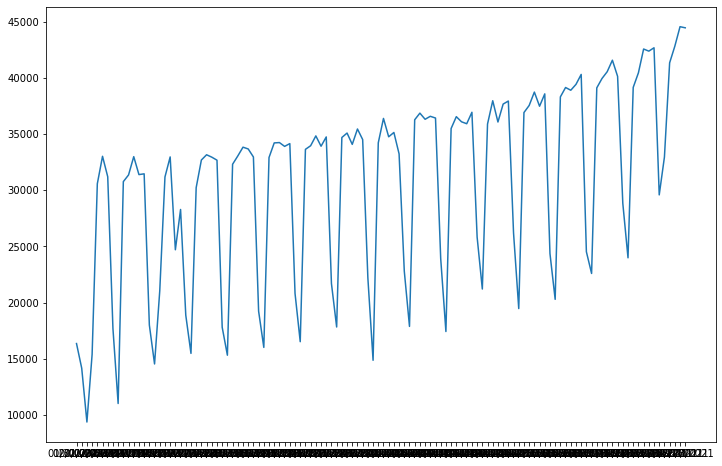

In [10]:
plt.figure(figsize=(12,8)) 
plt.plot(single_station_penn['DATE'],single_station_penn['DAILY_TOT_ABS'])

In [16]:
daily_by_station = turnstiles_daily_cleaned.groupby(['STATION','DATE']).DAILY_TOT_ABS.sum().reset_index()
station_mask = (daily_by_station['STATION'] == '34 ST-PENN STA') | (daily_by_station['STATION'] == '34 ST-HERALD SQ') | (daily_by_station['STATION'] == '86 ST') |(daily_by_station['STATION'] == '125 ST') | (daily_by_station['STATION'] == 'GRD CNTRL-42 ST')

daily_by_station_top = daily_by_station[station_mask].reset_index()
daily_by_station_top

,index,STATION,DATE,DAILY_TOT_ABS
0,1060,125 ST,01/31/2021,14832.0
1,1061,125 ST,02/01/2021,11367.0
2,1062,125 ST,02/02/2021,9760.0
3,1063,125 ST,02/03/2021,15253.0
4,1064,125 ST,02/04/2021,24090.0
...,...,...,...,...
585,27599,GRD CNTRL-42 ST,05/24/2021,13471.0
586,27600,GRD CNTRL-42 ST,05/25/2021,30313.0
587,27601,GRD CNTRL-42 ST,05/26/2021,32584.0
588,27602,GRD CNTRL-42 ST,05/27/2021,32940.0


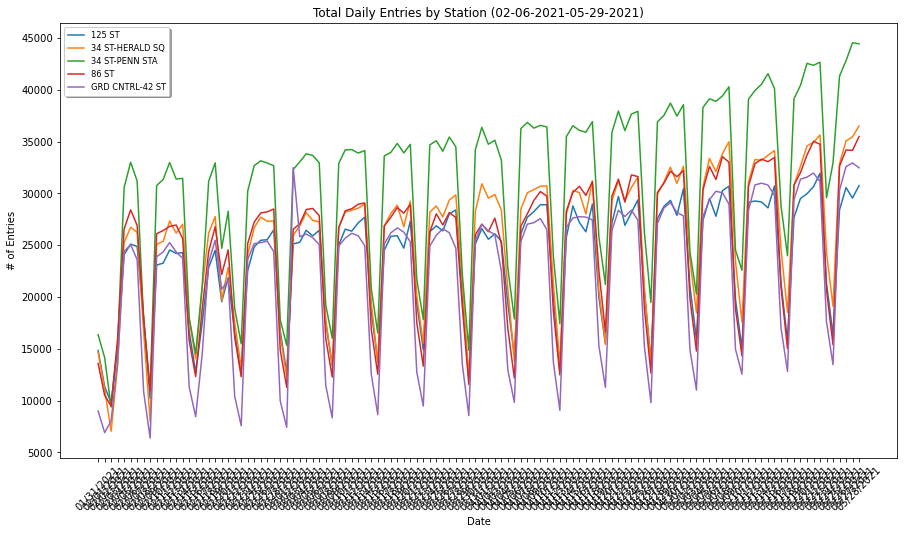

In [17]:
plt.figure(figsize=(15,8)) 
for i, group in daily_by_station_top.groupby('STATION'):
    plt.plot(group['DATE'], group['DAILY_TOT_ABS'], label = i)

plt.legend(shadow = True, loc = 0, fontsize = 'small')
plt.ylabel('# of Entries')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title('Total Daily Entries by Station (02-06-2021-05-29-2021)')

plt.savefig('daily_entries_by_station.png', bbox_inches = 'tight')

In [18]:
daily_by_station_top['DAY_OF_WEEK_NUM'] = pd.to_datetime(daily_by_station_top['DATE']).dt.dayofweek
daily_by_station_top

,index,STATION,DATE,DAILY_TOT_ABS,DAY_OF_WEEK_NUM
0,1060,125 ST,01/31/2021,14832.0,6
1,1061,125 ST,02/01/2021,11367.0,0
2,1062,125 ST,02/02/2021,9760.0,1
3,1063,125 ST,02/03/2021,15253.0,2
4,1064,125 ST,02/04/2021,24090.0,3
...,...,...,...,...,...
585,27599,GRD CNTRL-42 ST,05/24/2021,13471.0,0
586,27600,GRD CNTRL-42 ST,05/25/2021,30313.0,1
587,27601,GRD CNTRL-42 ST,05/26/2021,32584.0,2
588,27602,GRD CNTRL-42 ST,05/27/2021,32940.0,3


In [14]:
daily_by_station_sum = daily_by_station_top.groupby(['STATION','DAY_OF_WEEK_NUM']).DAILY_TOT_ABS.sum().reset_index()
daily_by_station_sum.head()

,STATION,DAY_OF_WEEK_NUM,DAILY_TOT_ABS
0,125 ST,0,233370.0
1,125 ST,1,418093.0
2,125 ST,2,451171.0
3,125 ST,3,457446.0
4,125 ST,4,457773.0


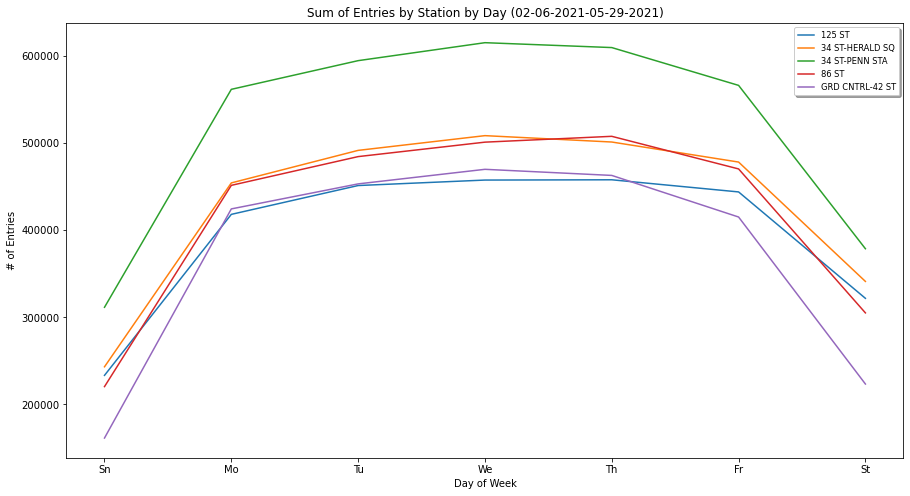

In [15]:
plt.figure(figsize=(15,8)) 
for i, group in daily_by_station_sum.groupby('STATION'):
    plt.plot(group['DAY_OF_WEEK_NUM'], group['DAILY_TOT_ABS'], label = i)
    
plt.legend(shadow = True, loc = 0, fontsize = 'small')

plt.ylabel('# of Entries')
plt.xlabel('Day of Week')
plt.xticks(np.arange(7),['Sn','Mo','Tu','We','Th','Fr','St'])
plt.title('Sum of Entries by Station by Day (02-06-2021-05-29-2021)')

plt.savefig('daily_entries_sum_week.png', bbox_inches = 'tight')